# First exploratory analysis of idealista data 
**status: 29.11.2023**

Goal of the analysis is to investigate the quality of the idealista data, transform it for analysis, and get a first understanding of the real estate prices in Madrid and how they are affected by different variables such as distance from the city center and characteristics of the flat.

**About the data**
- includes data from 10.11.2023, 17.11.2023 and 25.11.2023
- number of data points: 1671

**Data quality**
- Duplicates: 
    - In some cases (13 out of 1.685), the price of the flat is changed after it is first posted, in which case the data point is included twice in our analysis. Usually, the price is lowered, however, in a couple of cases it increases. Keep in mind that we currently only extract data once a week, so if a flat price changed and then the flat was taken off the market within the week, or the price changed several times, we would not be aware of it.
- Outliers:
    - Low price by area: I did not find a reason to exlucde flats with the lowest prices by area (< 10 €/m2). None of the flats with very low price per area have been flagged as scam by idealista since the data was retrieved. They all lie in areas outside of central Madrid and have a large size.
    - High price by area: For flats with very high prices by area (< 50 €/m2), several flats could only be rented month-wise. Another flat has since decreased the price by 1.500 €, bringing the price per m2 down to roughly 40€/m2. --> It makes sense to exclude these flats as outliers.
- Missing values:
    - there are some missing values for
        - floor (59), exterior (33) --> these might need to be excluded for some analyses but overall it is a small number
        - furnished (480) --> this is due to a change in the way we extract the data since the first date
        - parking_space_price (1582), subtypology (1444), name (1446) and text (1446). --> these fields do not need to be always filled

Overall we did not find any major issues with the data quality.
    
**Average prices**
- The median *price per area* in all the areas we included Madrid is *21.9 €/m2* (versus *24.2 €/m2* in the centre). The mean price is slightly higher (*23.3 €/m2* versus *25.5 €/m2* in the centre), indicating that there are some outliers in the higher price range. This can also be seen in the boxplot.
- The median *price* in Madrid is roughly *1750 €* (identical in the centre). The mean price is noticeably higher (*2.260 €/m2* versus *2.280 €/m2* in the centre), indicating that there are some outliers in the higher price range. Note that we only retrieved data from flats that lie within a 5 km radius of Sol (due to restrictions in the number of free API calls per month).


**Outlook**
- there are several variables that are interesting for more detailed analysis, including:
    * floor
    * exterior (True/False)
    * furnished (True/False)
    * neighborhood
    * distance from city center
- in the future, when we have more data, it would be interesting to investigate cases in which the price for a flat was changed. For now, we just include the latest price in our analysis.

**Summary**

## 1 Load data

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import os
import ast
import math

import warnings
warnings.filterwarnings("ignore")

In [53]:
pd.set_option('display.max_columns', None)


In [54]:
os.chdir('C:\\Users\\janin\\Desktop\\repos\\real_estate_madrid')

In [55]:
df = pd.read_csv("data/idealista_data.csv")

## 2 Clean up data

In [56]:
df.shape

(1669, 44)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   propertyCode       1669 non-null   int64  
 1   thumbnail          1663 non-null   object 
 2   externalReference  1142 non-null   object 
 3   numPhotos          1669 non-null   int64  
 4   floor              1610 non-null   object 
 5   price              1669 non-null   float64
 6   propertyType       1669 non-null   object 
 7   operation          1669 non-null   object 
 8   size               1669 non-null   float64
 9   exterior           1636 non-null   object 
 10  rooms              1669 non-null   int64  
 11  bathrooms          1669 non-null   int64  
 12  address            1669 non-null   object 
 13  province           1669 non-null   object 
 14  municipality       1669 non-null   object 
 15  district           1669 non-null   object 
 16  country            1669 

### 2.1 Explode columns with dictionary as values

In [58]:
def explode_json_columns(
    df: pd.DataFrame,
    columns: list[str] = ['parkingSpace', 'detailedType', 'suggestedTexts', 'labels', 'highlight']
) -> pd.DataFrame:
    df_exploded = df.copy(deep=True)
    for c in columns:
        if c == 'labels':
            df_column_exploded = df_exploded[c].apply(lambda x: ast.literal_eval(x)[0] if pd.notnull(x) else x).apply(pd.Series).drop(columns=0)
        else:
            df_column_exploded = df_exploded[c].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else x).apply(pd.Series)

        if 0 in df_column_exploded.columns:
            df_column_exploded.drop(columns=0, inplace=True)
        df_exploded = df_exploded.drop(columns = c).join(df_column_exploded)
    return df_exploded

In [59]:
df = explode_json_columns(df)

### 2.2 Drop unnecessary columns

In [60]:
df.drop(columns = ['thumbnail', 'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'topNewDevelopment', 'superTopHighlight', 'status', 'topPlus'], inplace=True)

### 2.3 Change column names from camel case to snake case

In [61]:
df.columns = (df.columns
                .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                .str.lower()
             )

### 2.4 Calculate price by area

In [62]:
# calculate price by area
df['price_by_area'] = round(df['price'] / df['size'],1)

### 2.5 Clean up boolean variables

#### Remove boolean columns that have the same value for each entry

In [63]:
def cleanup_boolean_columns(
    df: pd.DataFrame,
)-> pd.DataFrame:
    df_cleaned = df.copy(deep=True)
    for c in df_cleaned.columns:
        if df_cleaned[c].dtype == 'bool':
            display(df_cleaned.groupby(c).price.count())
            print('\n')
            if df_cleaned[c].nunique() == 1: 
                df_cleaned.drop(columns = c, inplace=True)
                print("Dropped colummn", c)
    return df_cleaned

In [64]:
df = cleanup_boolean_columns(df)

show_address
False    1376
True      293
Name: price, dtype: int64

has_video
False    1190
True      479
Name: price, dtype: int64

new_development
False    1669
Name: price, dtype: int64



Dropped colummn new_development


#### Convert boolean columns with dtype object to string

In [65]:
# convert column has_parking_space to boolean
def convert_string_to_bool(
    df: pd.DataFrame,
    columns: list[str] = ["has_parking_space", "is_parking_space_included_in_price", "has_lift"]
) -> pd.DataFrame:
    for c in columns:
        df[c].fillna(0, inplace=True)
        df[c] = df[c].astype('bool')
    return df

In [66]:
df = convert_string_to_bool(df=df)

### 2.6 Exclude categorical variables with the same value for every entry

In [67]:
# plot categorical variables:
cat = df.select_dtypes(include=['object']).columns

In [68]:
# show categorical columnns that have the same value for each entry
# these variables we do not need to plot
for c in cat:
    if df[c].nunique() == 1:
        display(df.groupby(c).price.count())
        print('\n')

operation
rent    1669
Name: price, dtype: int64

province
Madrid    1669
Name: price, dtype: int64

municipality
Madrid    1669
Name: price, dtype: int64

country
es    1669
Name: price, dtype: int64

group_description
Destacado    147
Name: price, dtype: int64

In [69]:
# convert colun group_description to boolean since it only has one value
df["destacado"] = (df['group_description'] == "Destacado")
df.drop(columns="group_description", inplace=True)

In [70]:
df["destacado"].dtype

dtype('bool')

### 2.7 Clean up floor column

In [71]:
df.floor.unique()

array(['2', '1', '5', 'bj', '4', '3', '6', 'ss', nan, '7', '20', '9',
       '14', '12', '8', '15', '10', 'en', '11', '24', '13', 'st', '16'],
      dtype=object)

In [72]:
df.loc[df['floor'] == 'st', 'floor'] = -1
df.loc[df['floor'] == 'ss', 'floor'] = -0.5
df.loc[df['floor'] == 'bj', 'floor'] = 0
df.loc[df['floor'] == 'en', 'floor'] = 0.5

In [73]:
df.floor = df.floor.astype('float')

## 3 Overview on the data

### 3.1 Categorical and boolean variables

In [74]:
cat_plots = ['floor', 'property_type', 'exterior', 'district', 'neighborhood', 'has_lift', 'furnished', 
             'insert_date', 'has_parking_space', 'is_parking_space_included_in_price', 'typology', 'sub_typology']

In [75]:
def plot_categorical_columns(
    df: pd.DataFrame,
    categorical_columns_to_plot: list = None,
):
    if categorical_columns_to_plot is None:
        categorical_columns_to_plot = df.select_dtypes(include='object').columns
    
    plot_in_own_row = [x for x in categorical_columns_to_plot if (len(df[x].unique()) > 10) & (len(df[x].unique()) < 100)]
    plot_in_subplot = [x for x in categorical_columns_to_plot if len(df[x].unique()) <= 10]
    
    # plot columns with small number of unique values
    
    # set up subplots based on number of categorical columns
    num_rows = (math.ceil(len(plot_in_subplot) / 3))
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))
    # flatten the axes array to make indexing easier
    axes = axes.flatten()

    # create boxplots for each categorical column
    for i, col in enumerate(plot_in_subplot):
        sns.boxplot(x = df[col], y = df["price_by_area"], ax=axes[i])
        axes[i].set_title('Price by area per ' + col)
        # rotate x labels if more than 5 unique values
        if (len(df[col].unique()) > 5) & (max([len(str(x)) for x in df[col].unique()]) > 3):
            axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show();

    # plot columns with a lot of unique values individually
    for i, col in enumerate(plot_in_own_row):
        fix, ax = plt.subplots(figsize=(15,6))
        ax.set_title('Price by area ' + col)
        sns.boxplot(x = df[col], y = df["price_by_area"], ax=ax)
        if max([len(str(x)) for x in df[col].unique()]) > 3:
            if len(df[col].unique()) > 25:
                ax.tick_params(axis='x', rotation=75, labelsize=6)
            else:
                ax.tick_params(axis='x', rotation=75, labelsize=10)
        plt.tight_layout()
        plt.show();


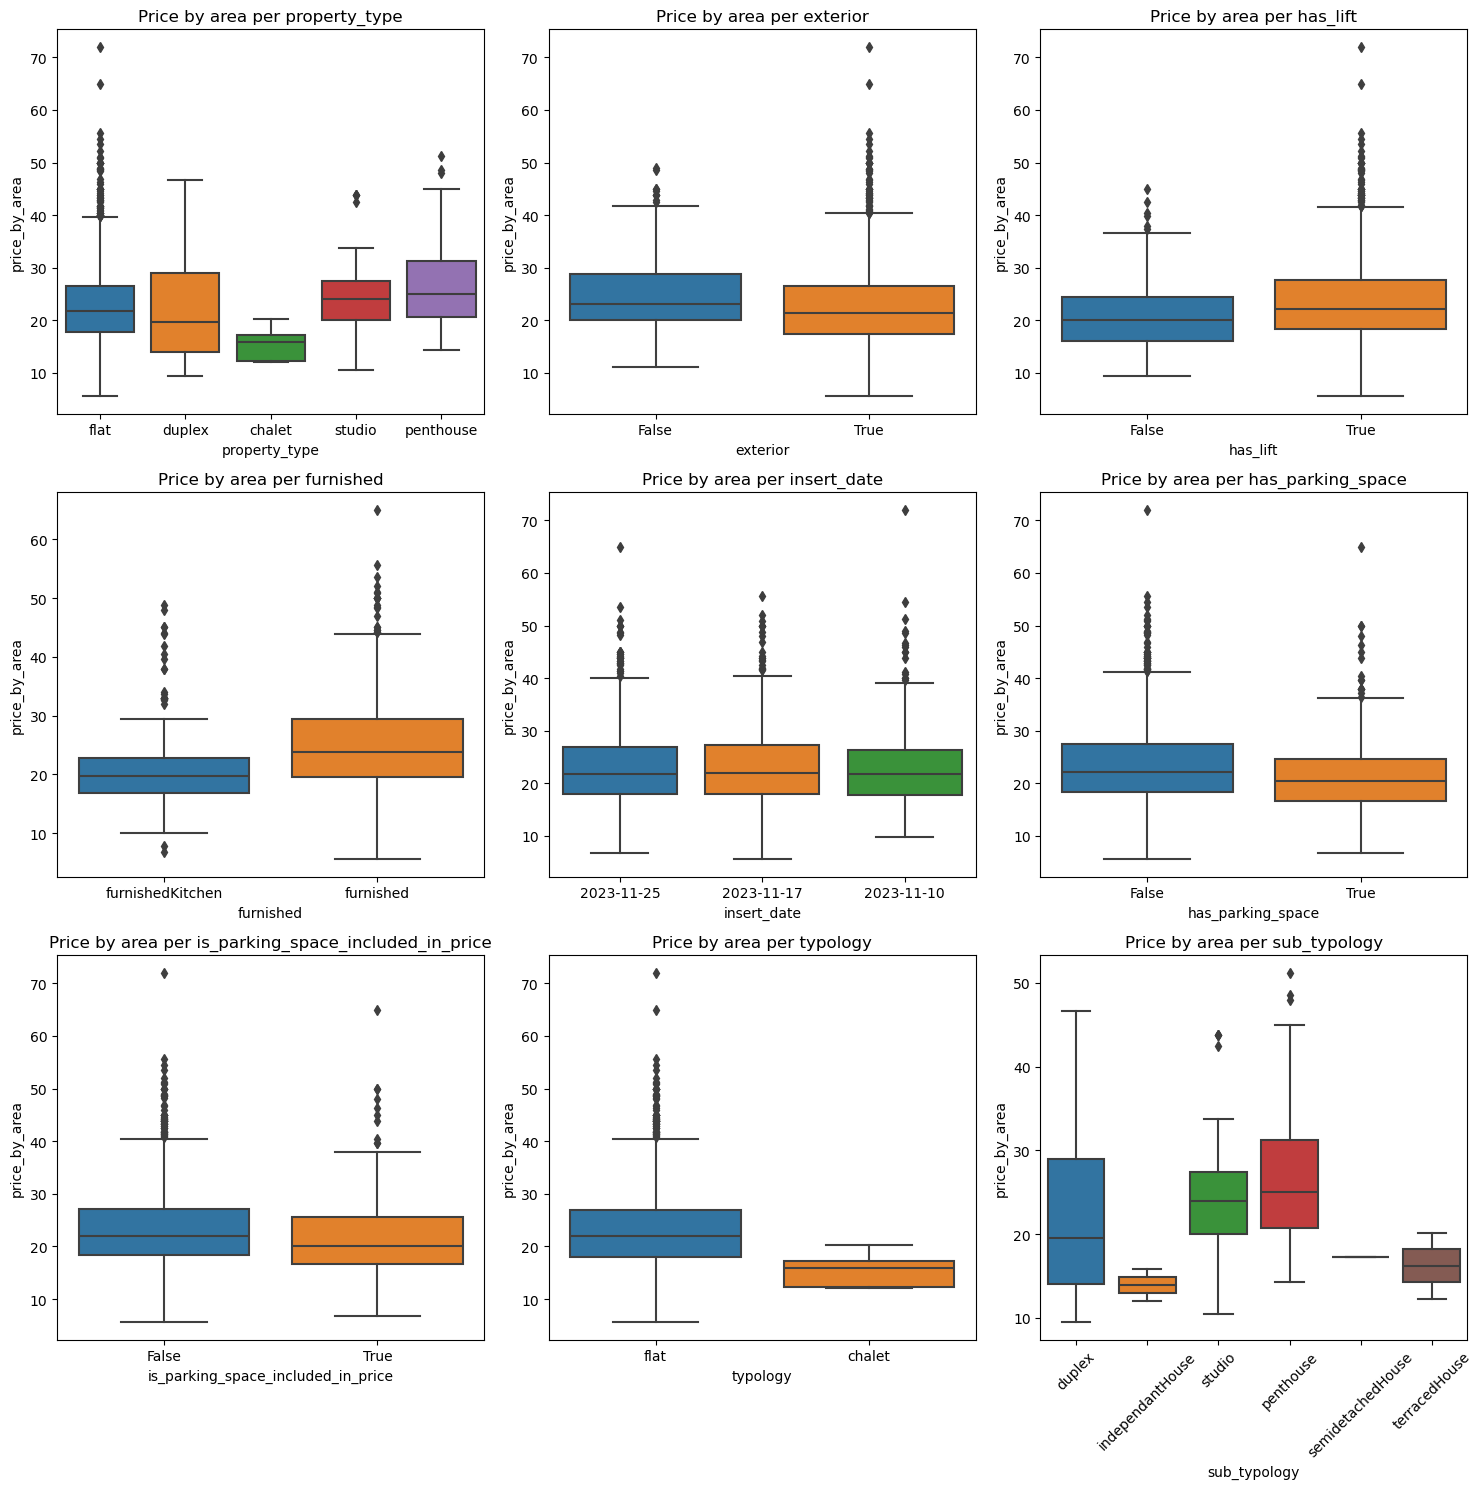

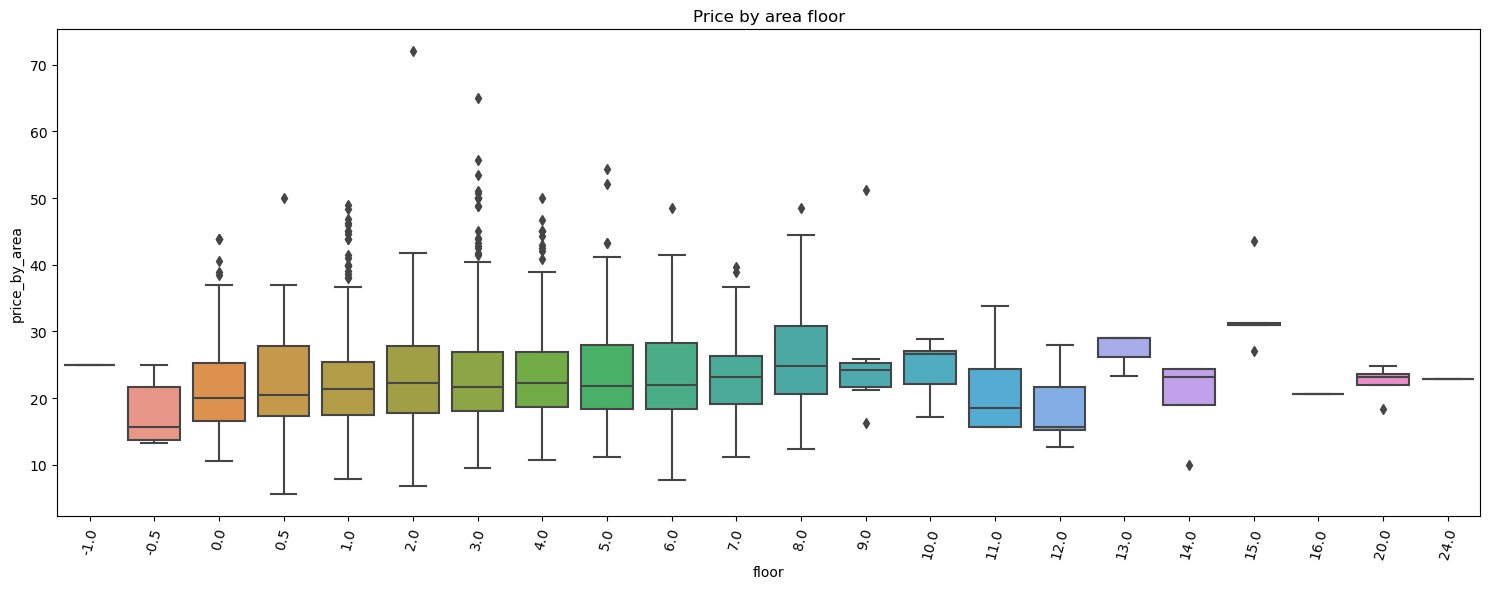

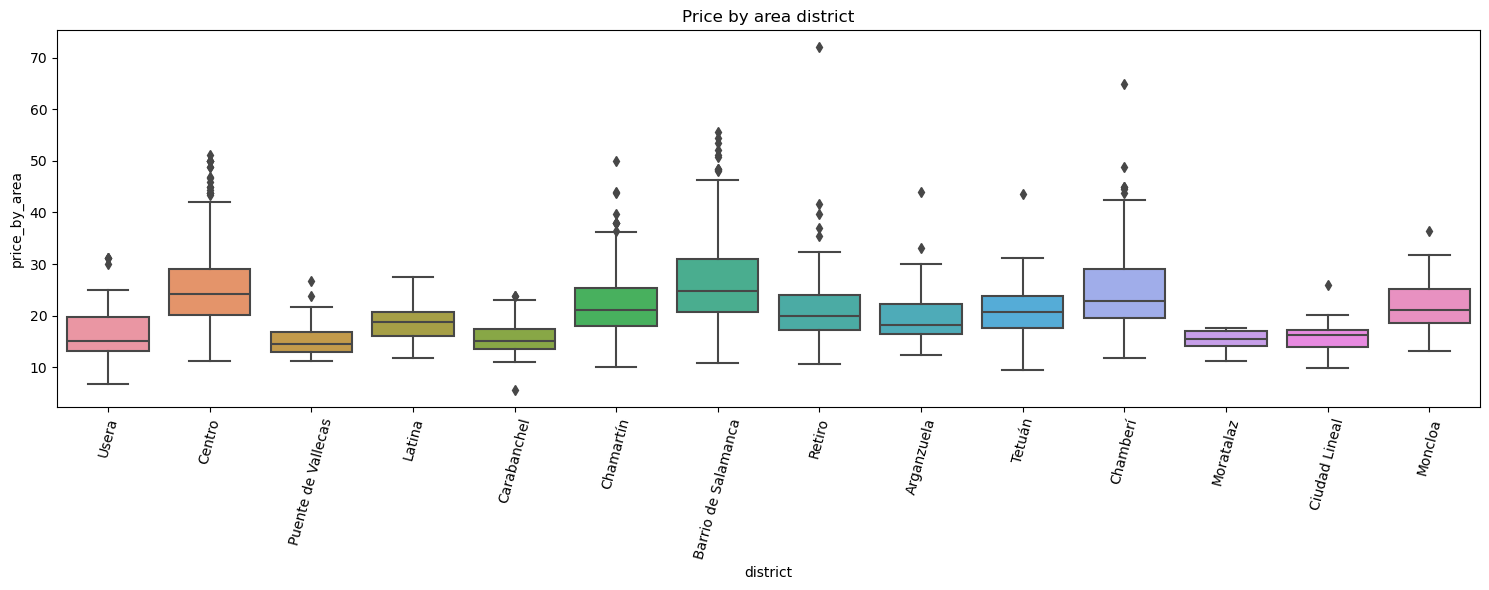

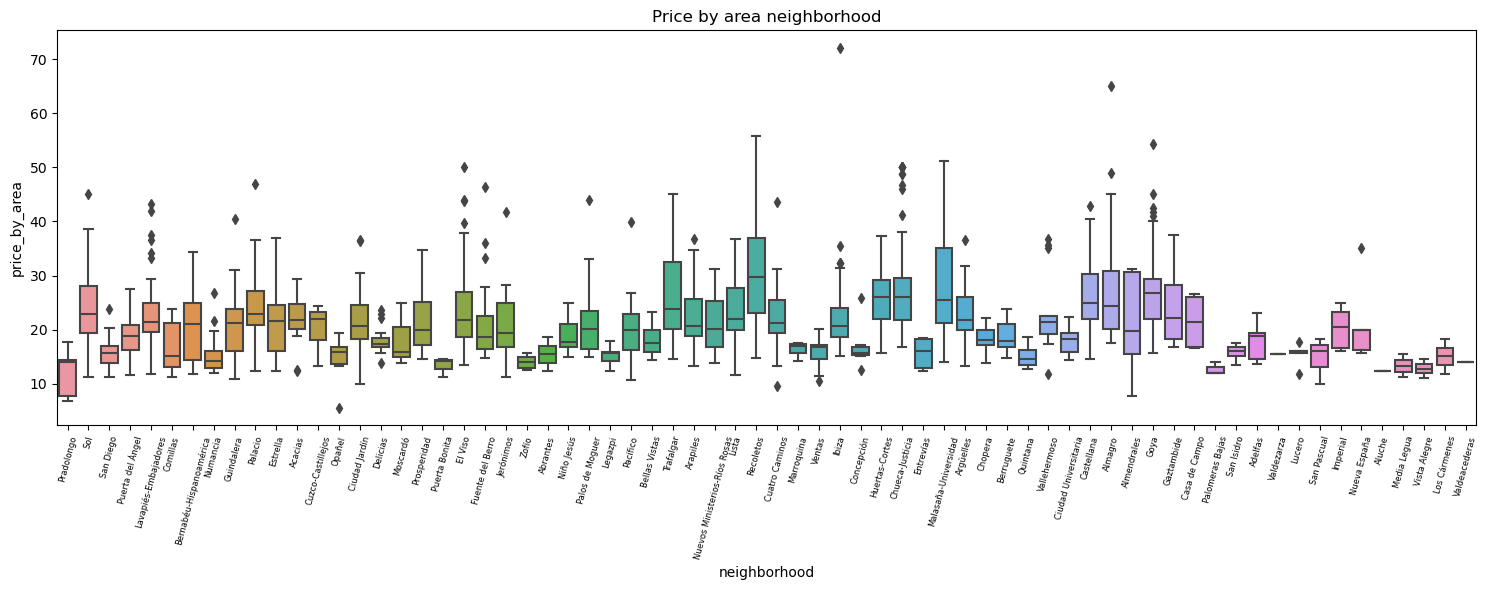

In [76]:
plot_categorical_columns(df, cat_plots)

### 3.2 Continuous variables

#### Flat size versus price

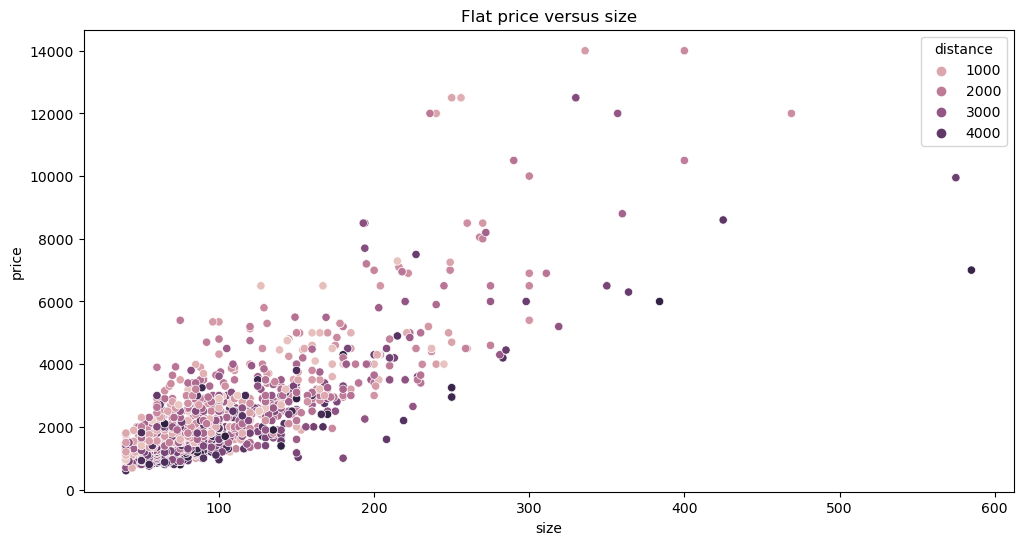

In [77]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x=df['size'],y=df.price,hue=df['distance'])
ax.set_title("Flat price versus size")
plt.show();

#### Price by area versus distance from city center

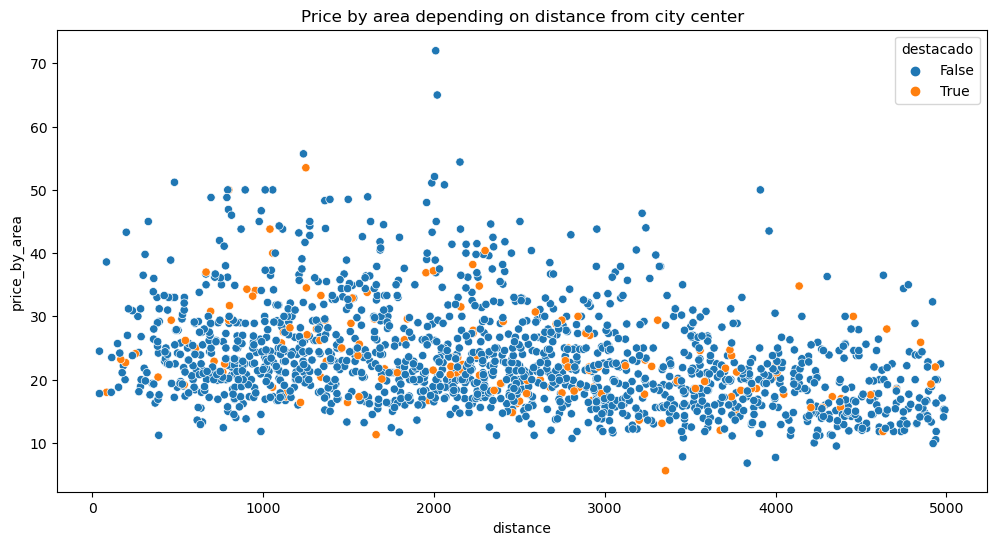

In [78]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,6))

sns.scatterplot(y=df['price_by_area'],x=df.distance,hue=df['destacado'], legend='auto')
ax.set_title("Price by area depending on distance from city center")
plt.show();

## 4 Check data quality

### 4.1 Check for duplicates

In [80]:
df.duplicated().sum()

0

In [81]:
df.duplicated(subset=['property_code']).sum()

11

In [82]:
pd.set_option('display.max_colwidth', 50)
df.loc[df.duplicated(subset=['property_code'], keep=False), ['property_code', 'insert_date', 'price', 'size']].sort_values(['property_code', 'insert_date'])

,property_code,insert_date,price,size
1642,96919017,2023-11-10,1390.0,65.0
924,96919017,2023-11-17,1290.0,65.0
1287,103096348,2023-11-10,2500.0,109.0
748,103096348,2023-11-17,2300.0,109.0
1403,103132333,2023-11-10,1292.0,76.0
912,103132333,2023-11-17,1465.0,76.0
1389,103138046,2023-11-10,600.0,40.0
907,103138046,2023-11-17,750.0,40.0
1604,103138197,2023-11-10,2625.0,60.0
1161,103138197,2023-11-17,2290.0,60.0


In [83]:
df.insert_date = pd.to_datetime(df.insert_date)
df.insert_date = pd.Categorical(df.insert_date)

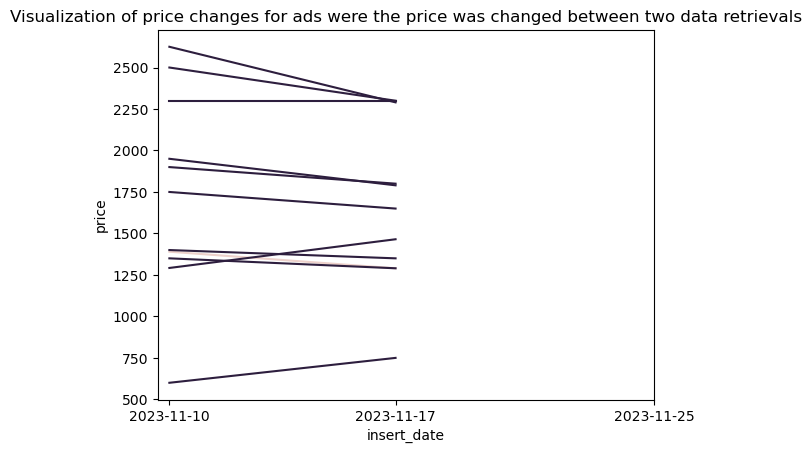

In [84]:
fig = sns.lineplot(data=df.loc[df.duplicated(subset=['property_code'], keep=False)], x='insert_date', y='price', hue='property_code', legend=False)
plt.xticks(df.insert_date.unique())
plt.title("Visualization of price changes for ads were the price was changed between two data retrievals")
plt.show();

In [85]:
df.property_code.nunique()

1658

**Conclusion**

In some cases (13 out of 1.685), the price of the flat is changed after it is first posted. Usually, the price is lowered, however, in a couple of cases it increases. Keep in mind that we currently only extract data once a week, so if a flat price changed and then the flat was taken off the market within the week, or the price changed several times, we would not be aware of it.

### 4.2 check for very high / low prices

#### Low prices

In [86]:
df.loc[df.price_by_area <= 10, ['property_code', 'num_photos', 'price', 'size', 'district', 'price_by_area', 'url']]

,property_code,num_photos,price,size,district,price_by_area,url
0,103282120,27,1030.0,151.0,Usera,6.8,https://www.idealista.com/inmueble/103282120/
1,103239519,31,1170.0,150.0,Usera,7.8,https://www.idealista.com/inmueble/103239519/
220,103224507,27,950.0,100.0,Tetuán,9.5,https://www.idealista.com/inmueble/103224507/
617,103196438,45,2200.0,219.0,Chamartín,10.0,https://www.idealista.com/inmueble/103196438/
823,100509925,25,1000.0,180.0,Carabanchel,5.6,https://www.idealista.com/inmueble/100509925/
824,87838759,28,1600.0,208.0,Usera,7.7,https://www.idealista.com/inmueble/87838759/
1377,103126654,17,1390.0,140.0,Ciudad Lineal,9.9,https://www.idealista.com/inmueble/103126654/


**Conclusion**

- None of the flats with very low price per area have been flagged as scam by idealista since the data was retrieved. 
- They all lie in areas outside of central Madrid and have a large size. 
- One of the flats can only be rented by months.
--> Overall, it seems that we do not need to exclude flats with low price per area.

#### High prices

In [87]:
df.loc[df.price_by_area > 50, ['property_code', 'num_photos', 'price', 'size', 'district', 'price_by_area', 'url']]

,property_code,num_photos,price,size,district,price_by_area,url
614,103226603,12,4700.0,92.0,Barrio de Salamanca,51.1,https://www.idealista.com/inmueble/103226603/
615,103232479,27,5350.0,100.0,Barrio de Salamanca,53.5,https://www.idealista.com/inmueble/103232479/
616,103280349,25,3900.0,60.0,Chamberí,65.0,https://www.idealista.com/inmueble/103280349/
1187,103152154,25,12000.0,236.0,Barrio de Salamanca,50.8,https://www.idealista.com/inmueble/103152154/
1188,103134614,11,3645.0,70.0,Barrio de Salamanca,52.1,https://www.idealista.com/inmueble/103134614/
1189,103195996,43,5350.0,96.0,Barrio de Salamanca,55.7,https://www.idealista.com/inmueble/103195996/
1611,103090467,49,6500.0,127.0,Centro,51.2,https://www.idealista.com/inmueble/103090467/
1612,103111472,12,3915.0,72.0,Barrio de Salamanca,54.4,https://www.idealista.com/inmueble/103111472/
1613,103072718,35,5400.0,75.0,Retiro,72.0,https://www.idealista.com/inmueble/103072718/


**Conclusion**

- None of the flats with very high price per area have been flagged as scam by idealista since the data was retrieved. 
- They all lie in areas in central Madrid, mostly in Salamanca. 
- 4 of the flats can only be rented by months.
- Another one has since decreased the price by 1.500 €, bringing the price per m2 down to roughly 40€/m2.
--> It makes sense to exclude these flats as outliers.

### 4.3 Check for missing values

In [88]:
df.isna().sum()

property_code                            0
external_reference                     527
num_photos                               0
floor                                   59
price                                    0
property_type                            0
operation                                0
size                                     0
exterior                                33
rooms                                    0
bathrooms                                0
address                                  0
province                                 0
municipality                             0
district                                 0
country                                  0
neighborhood                             0
latitude                                 0
longitude                                0
show_address                             0
url                                      0
distance                                 0
description                              8
has_video  

In [89]:
df.loc[df.furnished.isna()].insert_date.unique()

[2023-11-10]
Categories (3, datetime64[ns]): [2023-11-10, 2023-11-17, 2023-11-25]

**Conclusion**

- there are some missing values for 
     - floor (59), exterior (33)
    --> these might need to be excluded for some analyses but overall it is a small number
    - furnished (480)
    --> this is due to a change in the way we extract the data since the first date
    - parking_space_price (1582), subtypology (1444), name (1446) and text (1446). 
    --> these fields do not need to be always filled

### 4.4 Inspect data distribution

#### Price by area (complete dataset)

In [90]:
round(df.price_by_area.describe(),1)

count    1669.0
mean       23.3
std         7.8
min         5.6
25%        17.9
50%        21.9
75%        26.9
max        72.0
Name: price_by_area, dtype: float64

In [91]:
round(df.price_by_area.median(),1)

21.9

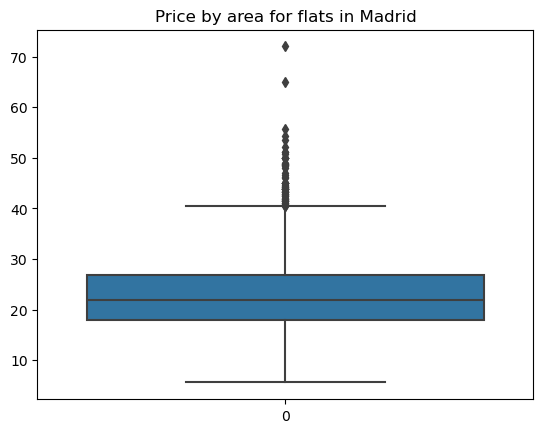

In [92]:
sns.boxplot(data=df.price_by_area)
plt.title("Price by area for flats in Madrid")

plt.show();

#### Price by area (centro)

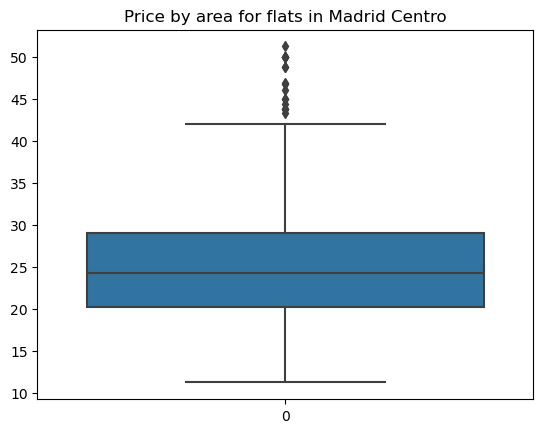

In [93]:
import numpy as np

sns.boxplot(data=np.array(df.loc[df.district == "Centro", "price_by_area"]))
plt.title("Price by area for flats in Madrid Centro")

plt.show();

In [94]:
df.loc[df.district == "Centro", "price_by_area"].median()

24.2

In [95]:
df.loc[df.district == "Centro", "price_by_area"].mean()

25.446867167919798

**Summary**

The median price per area in all the areas we included Madrid is 21.9 €/m2 (versus 24.2 €/m2 in the centre). The mean price is slightly higher (23.3 €/m2 versus 25.5 €/m2 in the centre), indicating that there are some outliers in the higher price range. This can also be seen in the boxplot.

#### Price (complete dataset)

Since the price by area is calculated using the "superficie construída" which is not the actual usable size ("superficie útil"), the real price by usable area would be even higher. To compare, we also inspect the price in Euro.

In [96]:
round(df.price.describe(),1)

count     1669.0
mean      2260.1
std       1689.8
min        600.0
25%       1300.0
50%       1700.0
75%       2600.0
max      14000.0
Name: price, dtype: float64

In [97]:
round(df.price.median(),1)

1700.0

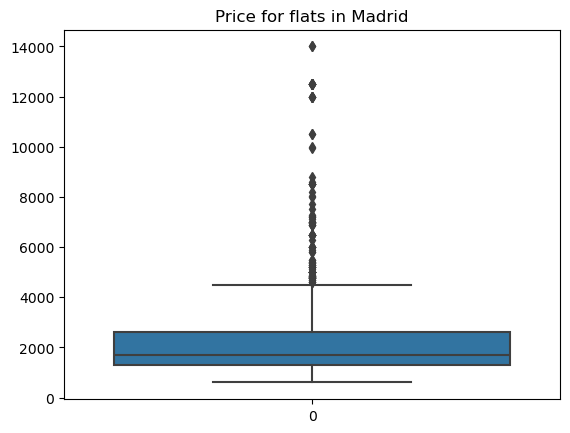

In [98]:
sns.boxplot(data=df.price)
plt.title("Price for flats in Madrid")

plt.show();

#### Centre

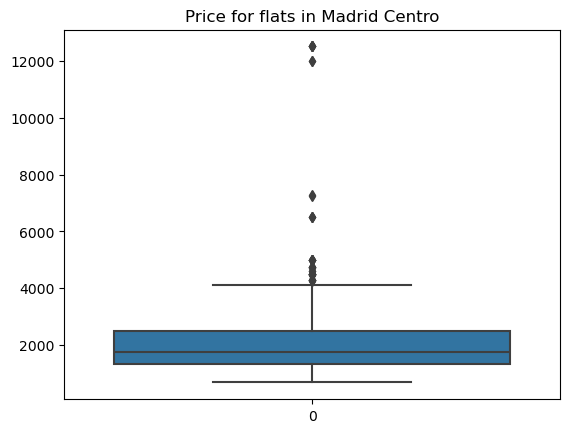

In [99]:
import numpy as np

sns.boxplot(data=np.array(df.loc[df.district == "Centro", "price"]))
plt.title("Price for flats in Madrid Centro")

plt.show();

In [100]:
df.loc[df.district == "Centro", "price"].median()

1750.0

In [101]:
df.loc[df.district == "Centro", "price"].mean()

2281.3533834586465

**Summary**

The median price in Madrid is roughly 1750 € (identical in the centre). The mean price is noticeably higher (2.260 €/m2 versus 2.280 €/m2 in the centre), indicating that there are some outliers in the higher price range. Note that we only retrieved data from flats that lie within a 5 km radius of Sol (due to restrictions in the number of free API calls per month).

## 5 Save data

In [111]:
df.drop(columns=["address", "description", "title", "subtitle"]).to_csv("analysis/data/df_exploratory_analysis_2023_11_29.csv", index=False)

In [112]:
df.sample()

,property_code,external_reference,num_photos,floor,price,property_type,operation,size,exterior,rooms,bathrooms,address,province,municipality,district,country,neighborhood,latitude,longitude,show_address,url,distance,description,has_video,has_lift,price_by_area,filters,furnished,insert_date,has_parking_space,is_parking_space_included_in_price,parking_space_price,typology,sub_typology,subtitle,title,name,text,destacado
1471,103067110,C0141-00086,15,4.0,3200.0,flat,rent,143.0,True,2,2,Plaza Mayor,Madrid,Madrid,Centro,es,Sol,40.416387,-3.708624,False,https://www.idealista.com/inmueble/103067110/,452,¡Bienvenido a tu nuevo hogar en el corazón de ...,False,True,22.4,"['Alquilar', 'Viviendas', 'Sol', 'De más de 20...",NaN,2023-11-10,False,False,NaN,flat,NaN,"Sol, Madrid",Piso en Plaza Mayor,NaN,NaN,False
